# CSCI 3022 Homework
<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below. 

In [1]:
NAME = "Tyler Nevell"
COLLABORATORS = "Stephen Kay, Cody Hegwer"

If you referenced any web sites or solutions not of your own creation, list those references here:

* List any external references or resources here

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%matplotlib inline

# Overview

In this homework, you're going to compute confidence intervals for two different datasets using multiple methods. The first data set is quite large, and you should find that the different techniques yield similar answers. The second dataset is much smaller. You will then solve a problem concerning confidence intervals for proportions (*e.g.* polling results).

# Problem #1 - Traffic Comparison [50 pts]

The British [Luddite](https://en.wikipedia.org/wiki/Luddite) society argues that modern traffic lights cause more accidents than traditional "give way" (yield) intersections and that the problem is getting worse over time.

Being a smart data scientist, you realize that "correlation can't prove causation", but you can at least determine if automatic intersections have more dangerous accidents that traditional intersections. Thinking quickly you [realize that traffic accident data is available](https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales) and has been provided to you for the 2005-2007 year spand in the file 'accidents_2005_to_2007.csv'.

In [3]:
df = pd.read_csv('accidents_2005_to_2007.csv', dtype='unicode')

This datafile contains a number of columns [as described here](https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales/data). The data has a number of columns of interest. However, becasue the data set is large and somewhat unclean, you'll need to convert columns of interest into the appropriate data types. You should convert the following columns to their appropriate data types:
* Number_of_Casualties
* Junction_Control
* Year

Modify the dataframe `df` to have these columns converted to the appropriate types.

In [4]:
df.Junction_Control = df.Junction_Control.astype('category')
df.Number_of_Casualties = df.Number_of_Casualties.astype('int')
df.Year = df.Year.astype('int')

The 'Junction_Control' has a single machine-controlled taffic mechanism, 'Automatic traffic signal'. The other methods are all human controlled. Create a new column labeled `machine` that distinguishes the accidents involving automatic traffic light controls from the other accidents (e.g. stop sign, yield, etc).

In [5]:
df['machine'] = df.Junction_Control == 'Automatic traffic signal'

## The Luddite Arugment

We first show the data group by year and type of intersection or junction control.

In [6]:
df.groupby(['machine', 'Year']).describe()

Number_of_Casualties                                          \
                            count      mean       std  min  25%  50%  75%   
machine Year                                                                
False   2005             179251.0  1.362185  0.812971  1.0  1.0  1.0  1.0   
        2006             170416.0  1.366028  0.816717  1.0  1.0  1.0  1.0   
        2007             164223.0  1.360260  0.843032  1.0  1.0  1.0  1.0   
True    2005              19484.0  1.377746  0.854917  1.0  1.0  1.0  1.0   
        2006              18745.0  1.366284  0.839979  1.0  1.0  1.0  1.0   
        2007              17892.0  1.363403  0.771508  1.0  1.0  1.0  1.0   

                    
               max  
machine Year        
False   2005  29.0  
        2006  45.0  
        2007  68.0  
True    2005  35.0  
        2006  41.0  
        2007  13.0

The Luddite argument is that machine controlled intersections have a higher mean number of casulaties every year. In other words, in 2005, 1.362 is less than 1.377 and so one.

You argue that the table provides one estimate of the mean, and we'd really like to have an *interval estimate* -- it may be that some values were not reported, or there was mis-reporting or that values will differ in others years.

One way to compare this is to conduct a *hypothesis test*, and we will do that later in the semester. For now, we're going to compare our interval estimates for the mean with machines and without and if they overlap, we'll agree that the machine factor has no impact.

## Examine accident casualties

We are going to compare the number of accident casulaties in our data from machine controlled and non-machine controlled intersections. We'll first examine the data for the non-machine controlled intersections.

Create a vector `data_nonm` of the number of casualties for non-machine controlled intersections.

In [7]:
data_nonm = df[(df.machine == False)].Number_of_Casualties

Print the mean of the casulaties at non-machine intersections.

In [8]:
np.mean(data_nonm)

1.362844188444998

Prepare a similar set of data for machine controlled intersections called `data_m`.

In [9]:
data_m = df[(df.machine == True)].Number_of_Casualties


Print out the mean of that data.

In [10]:
np.mean(data_m)

1.3693448085386932

Print the difference between in the means of`data_m` and `data_nonm`. It should be small but positive.

In [11]:
np.mean(data_m) - np.mean(data_nonm)

0.006500620093695231

## A Reality Check

The two data sets have very similar means, and the value of the means should indicate that the Luddites have a point. This rocks you to your machine-loving core and you decide to make certain reality is still in your grasp.

You decide to first determine that the data for the non-machine casualties is not some how violating Markov's Inequality. That is, you seek to prove:

In [12]:
print('P(X > 2*', np.mean(data_nonm), '| < 1/2 )')

P(X > 2* 1.362844188444998 | < 1/2 )


Print out the relationship with in the form $P(X > t E[X]) = l $ for $t=2$ and substituting $E[X]$ and $l$ with the values from the data. Then print out True or False if the Markov inequality would be met using an equation involving the values for  $l$ and $t$. In other words, you evaluate an expression involving `data_nonm` and $t$ that yields True or False. You may use intermediate computations if that simplifies your code.

In [13]:
data_nonm_tEX = df[(df.machine == False) & (df.Number_of_Casualties > 2 * (np.mean(data_nonm)))].Number_of_Casualties

print(data_nonm_tEX.count()/data_nonm.count() < .5)

True


## Perhaps it's a fluke

There's a chance that the difference in the means is a fluke and that the varability of the data changes the conclusion that the machines are killing people. 

You decide to use Chebeyshev's inequality to determine if $P(|X-E[X]| > \delta) \leq 0.05%$ where $\delta$ is the difference between the mean of `data_m` and `data_nonm_`. In other words, you're trying to determine $P(|X-E[X]| < \delta) \geq 0.95$ for the `data_m` data -- that 95% of the `data_m` samples are within $\delta$ of the sample mean. If that's true, then you believe (perhaps incorrectly) that there's strong evidence that the means are "statistically identical".

Print out the expression for Chebyshev's inequality, $P(|X-E[X]| < \delta) = p$, substituting $\delta$ for the difference of the means and $p$ with the actual probability that the differences are less than $\delta$. 

Your output should be formated like `P(|X-E[X]|] <  1.2345 ) = 1.2345` but using the proper bound and actual percentage of the values for which the bound is true.

Then, print True or False if Chebyshev's inequality holds given the sample mean and variance, $\delta$ and $p$. In other words, you shoudl evaluate a conditional expression involving the $p$ computed above, the variance of the data and $\delta$.

In [14]:
delta = np.mean(data_m) - np.mean(data_nonm)
print(delta)
absval = data_m - np.mean(data_m)
comparison = absval > delta
prob = np.count_nonzero(comparison)/data_m.count()
stddev = np.std(data_m)
calced_delta = np.sqrt(stddev**2/0.05)
prob2 = np.count_nonzero(np.abs(data_m - np.mean(data_m)) < calced_delta)/data_m.count()
print(prob2)
p = stddev**2/delta**2
print(prob2 <= p)
print(np.count_nonzero(comparison))
print('P(|X-E[X]|] < ', delta, ') =', p)

#data_m.plot.kde()


0.006500620093695231
0.996240266567
True
13893
P(|X-E[X]|] <  0.006500620093695231 ) = 16072.182726987692


## Perhaps it's normal to be doubtful?

Things are looking bad for the machine lovers; to date, there's every reason to believe that machines at intersections cause more casualities thatn non-machine methods. The means are similar, but machines have slightly more casulaties. It's not likely that the difference between machines and non-machine casualties is so small that it's insigificant according to Chebyshev's inequality. 

You recognize that using *confidence intervals* may provide a solution. If the confidence intervals don't overlap, it's clear the means are different; if they do, you're willing to believe they're similar (again, perhaps incorrectly).

You recall that the Central Limit Theorem says that as $n \rightarrow \infty$, $\sqrt{n}\frac{\bar X_n - \mu}{\sigma}$ has a standard normal distribution. This leaves you confused, because when you look at distribution of data using a quantile-quantile plot, the number of casulaties is decidely **not** normal.

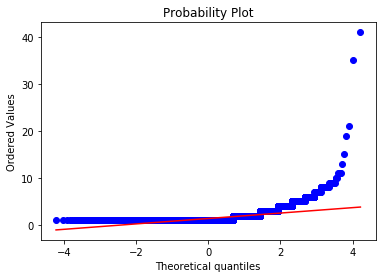

In [15]:
stats.probplot(data_m,plot=plt);

You consult your guru who points out you've misunderstood the CLT. The CLT says that *samples of the estimate of mean* will be normally distributed.

Construct `data_m_ests` as 1000 samples of the mean of the `data_m` data using the same procedure we used in class for *bootstrapping* your data. This will involve the `np.random.choice` function. Each estimate of the mean should involve at least 1000 samples.

In [16]:
data_m_ests = ([np.mean(np.random.choice(data_m, data_m.size))for x in range(1000)])

We will plot the histogram and the QQplot of the `data_m_ests` data:

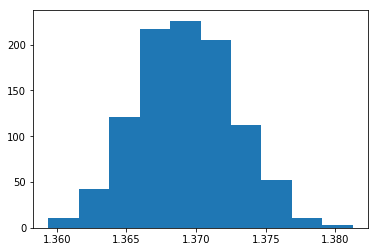

In [17]:
plt.hist(data_m_ests);

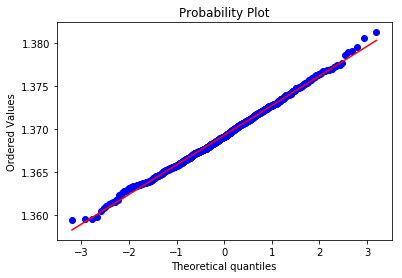

In [18]:
stats.probplot(data_m_ests,plot=plt);

## Compute the confidence interval using the Student-T distribution

You recall that it's usually safer to use the Student-T distribution if the underlying dataset is not normal. 

Using the Student-T distribution, compute the 95% confidence interval for both `data_m` and `data_nonm`. Print out the lower (2.5%), the mean and the upper (97.5%) limits. 

In [19]:
#m_mean = np.mean(data_m)
#nonm_mean = np.mean(data_nonm)

#tm = scipy.stats.t.ppf(.975, len(speed)-1)
#upm = np.mean(data_m) + (speed_se * tm)
#lowm = np.mean(data_m) - (speed_se * tm)
#t_m = [lowm, speed_m, upm]
#t_m

data_m_range = np.percentile(data_m_ests, [2.5, 97.5])
print('Machine related deaths has mean', np.mean(data_m), 'With lower CI', data_m_range[0], 'with upper CI', data_m_range[1])


Machine related deaths has mean 1.3693448085386932 With lower CI 1.36326508793 with upper CI 1.37627670569


In [20]:
data_nonm_ests = ([np.mean(np.random.choice(data_nonm, data_nonm.size))for x in range(1000)])
data_nonm_range = np.percentile(data_nonm_ests, [2.5, 97.5])   
print(data_nonm_range[0], data_nonm_range[1], np.mean(data_nonm))

1.36059414466 1.36508221604 1.362844188444998


Do the confidence intervals overlap? I.e. is there an overlap in the range of estimates of $\bar x_n$?

Because they do not overlap, we can be 95% confident that there is a statistical difference between both data sets.

## Compute the Confidence Interval Using Large Sample Assumption

You suddenly realize that you have have a lot of data and it's likely that the large data assumption can hold and you can use the standard normal rather than the Student-T distribution. You decide to do that to see if it changes the outcome.

Using the standard normal distribution, compute the 95% confidence interval for both `data_m` and `data_nonm`. Print out the lower (2.5%), the mean and the upper (97.5%) limits. 

In [21]:
print(data_m)

1         1
8         2
10        1
11        1
22        1
24        1
27        2
28        1
38        1
40        1
53        1
54        1
66        1
70        1
75        1
78        1
79        1
82        1
87        4
89        1
94        1
96        1
97        1
103       1
105       1
106       1
111       1
122       1
129       1
130       1
         ..
568957    1
568979    1
568992    1
569009    1
569049    1
569066    1
569067    1
569077    2
569080    1
569102    1
569117    2
569139    2
569167    1
569241    1
569281    1
569293    1
569333    1
569335    1
569342    1
569365    2
569372    1
569378    1
569423    2
569430    1
569499    1
569508    2
569694    1
569720    1
569773    1
569836    1
Name: Number_of_Casualties, Length: 56121, dtype: int32


In [22]:
data_m_mean = np.mean(data_m)
data_m_se = np.sqrt(np.var(data_m)/len(data_m))

Nmm = scipy.stats.norm.ppf(.975)

upNmm = data_m_mean + data_m_se * Nmm
lowNmm = data_m_mean - data_m_se * Nmm

data_m_snd_ci = [lowNmm, data_m_mean, upNmm]
data_m_snd_ci



[1.362526484970221, 1.3693448085386932, 1.3761631321071655]

In [23]:
data_nonm_mean = np.mean(data_nonm)
data_nonm_se = np.sqrt(np.var(data_nonm)/len(data_nonm))

Nmm = scipy.stats.norm.ppf(.975)

nonupNmm = data_nonm_mean + data_nonm_se * Nmm
nonlowNmm = data_nonm_mean - data_nonm_se * Nmm

data_nonm_snd_ci = [nonlowNmm, data_nonm_mean, nonupNmm]
data_nonm_snd_ci


[1.3605914962143919, 1.362844188444998, 1.3650968806756041]

Does this change the results of your comparisons of the mean?

Yes, the differences between the two means overlap.

## Bootstrap Confidence Intervals

Just to leave no stone un-turned, you decide to determine bootstrap confidence intervals to see if they're consistent with the prior confidence intervals.

To do this, it will be easiest to write a function `tstar(x,m)` that computes the bootstrap `t*` value for sample `x` and overall mean `m`. By this time in the class, we're going to assume you have learned how to write a simple function.

Provide function `t`:

In [24]:
def tstar(x,m):
    t = (np.mean(x) - m)/ np.sqrt(x.var()/len(x))
    return t


Using the bootstrap confidence interval process, compute the 95% confidence interval for both `data_m` and `data_nonm`. Print out the lower (2.5%), the mean and the upper (97.5%) limits. You should also print out the lower and upper estimates $c_l$ and $c_u$ determined by the bootstrap. Use 1000 sample means of 20000 values.

In [25]:
data_m_mean = np.mean(data_m)
data_m_boot = np.array([tstar(np.random.choice(data_m, 20000), data_m_mean) for x in range(1000)])

low_per = np.percentile(data_m_boot, 2.5)
upp_per = np.percentile(data_m_boot, 97.5)

c_l = np.sqrt(data_m.var()/data_m.count())*(low_per) + data_m_mean
c_u = np.sqrt(data_m.var()/data_m.count())*(upp_per) + data_m_mean

print("c_l: ", c_l)
print("The mean is: ", data_m_mean)
print("c_u: ", c_u)

#print(data_m_boot)

c_l:  1.36290851476
The mean is:  1.3693448085386932
c_u:  1.37564241732


In [26]:
data_nonm_mean = np.mean(data_nonm)
data_nonm_boot = np.array([tstar(np.random.choice(data_nonm, 20000), data_nonm_mean) for x in range(1000)])

low_pernon = np.percentile(data_nonm_boot, 2.5)
upp_pernon = np.percentile(data_nonm_boot, 97.5)

c_l_non = np.sqrt(data_nonm.var()/data_nonm.count())*(low_pernon) + data_nonm_mean
c_u_non = np.sqrt(data_nonm.var()/data_nonm.count())*(upp_pernon) + data_nonm_mean

print("c_l: ", c_l_non)
print("The mean is: ", data_nonm_mean)
print("c_u: ", c_u_non)

c_l:  1.36040861107
The mean is:  1.362844188444998
c_u:  1.3649340843


Are the confidence intervals symmetric? I.e. is $c_l = -c_u$? Also, do your earlier conclusions about the means still hold? Since the bootstrap depends on random samples, you may want to run this a few times befor answering.

Both the upper and lower confidence interval estimates are not symmetric. Our conclusion about the mean holds because it still falls between both confidence intervals.

## Can I just bootstrap the data?

Since you have a fair amount of data, you decide to settle the issue using an *empirical bootstrap* to estimate the distribution of the mean (*i.e.* not a bootstrap confidence interval).

For both `data_m` and `data_nonm`, compute the 95% confidence interval using a boostrap with 20,000 samples repeated 1,000 times.  For each dataset, print out the confidence interval in terms of (lower_bound, mean, upper_bound).

In [27]:
data_m_mean = np.mean(data_m)
data_m_emboot = np.array([np.mean(np.random.choice(data_m, 20000) - data_m_mean) for x in range(1000)])

low_per_em = np.percentile(data_m_emboot, 2.5)+data_m_mean
upp_per_em = np.percentile(data_m_emboot, 97.5)+data_m_mean

print("Lower Bound: ", low_per_em)
print("The mean is: ", data_m_mean)
print("Upper Bound: ", upp_per_em)

Lower Bound:  1.3592475
The mean is:  1.3693448085386932
Upper Bound:  1.3806025


In [28]:
data_nonm_mean = np.mean(data_nonm)
data_nonm_emboot = np.array([np.mean(np.random.choice(data_nonm, 20000) - data_nonm_mean) for x in range(1000)])

low_pernon_em = np.percentile(data_nonm_emboot, 2.5)+data_nonm_mean
upp_pernon_em = np.percentile(data_nonm_emboot, 97.5)+data_nonm_mean

print("Lower Bound: ", low_pernon_em)
print("The mean is: ", data_nonm_mean)
print("Upper Bound: ", upp_pernon_em)

Lower Bound:  1.3515475
The mean is:  1.362844188444998
Upper Bound:  1.37525375


Do the conclusions change compared to the previous methods?

Even though we have much wider intervals, we still reach the same conclusion.

## Comparison

In the cell below, you'll find a table into which you should enter your lower mean estimate, mean and upper mean estimate for each of the indicated techniques.

Round each result to four siginificant digits.

| Method | Dataset | $c_l$ | $\bar x_n$ | $c_u$ |
| :---:  | :------:|:-----:|:----------:|:----:|
| T-dist | m |1.3623|1.3693|1.3761| 
| T-dist | nonm |1.3606|1.3628|1.3652|
| Normal | M |1.3625|1.3693|1.3762|
| Normal | nonm |1.3606|1.3628|1.3651|
| Boot CI | m |1.3625|1.3693|1.376|
| Boot CI | nonm |1.3605|1.3628|1.3649|
| Emp. Boot | m |1.3581|1.3693|1.3807|
| Emp. Boot | nonm |1.3515|1.3628|1.3742  |




Examine this table and comment on the relationship between the confidence intervals from the T-distribution and the Normal distribution. Are they similar? Also comment on the relationship between the Normal distribution and the Bootstrap CI. Lastly, comment on the Bootstrap CI and the Empirical Bootstrap estimate; before answering the question, go back to your Empirical Bootstrap and draw much larger samples (e.g. 1000 samples of 200,000 rather than 20,000). 

T & Normal: Nearly Identical

Norm & BootStrap CI: Except for lower limits, they are nearly identical

Emp & Bootstrap: Biggest difference, becomes closer the larger the sample, nearly identical with a larger enough number.

# Problem #2 - Speed of light [25 points]

We will now address a smaller problem where we'll see more stark differences between the techniques.

We're going to use a reduced version of the the Michelson speed of light data. Because the Michelson data has 100 elements, we would find that the Student-T and Standard Normal distibution would give almost identical results. Although that's not "big data", it's useful to understand the difference between the Student-T and normal distribution in practice.

In [29]:
spd = np.array([  850.,   740.,   900.,  1070.,   930.,   850.,   950.,   980.,
         980.,   880.,  1000.,   980.,   930.,   650.,   760.,   810.,
        1000.,  1000.,   960.,   960.,   960.,   940.,   960.,   940.,
         880.,   800.,   850.,   880.,   900.,   840.,   830.,   790.,
         810.,   880.,   880.,   830.,   800.,   790.,   760.,   800.,
         880.,   880.,   880.,   860.,   720.,   720.,   620.,   860.,
         970.,   950.,   880.,   910.,   850.,   870.,   840.,   840.,
         850.,   840.,   840.,   840.,   890.,   810.,   810.,   820.,
         800.,   770.,   760.,   740.,   750.,   760.,   910.,   920.,
         890.,   860.,   880.,   720.,   840.,   850.,   850.,   780.,
         890.,   840.,   780.,   810.,   760.,   810.,   790.,   810.,
         820.,   850.,   870.,   870.,   810.,   740.,   810.,   940.,
         950.,   800.,   810.,   870.]) + 299000

This data is approximately normal because the deviation of the values represent measurement error in a constrained environment while measuring the speed of light.

We're going to select a subset of data values to be dataset. You'll be running this code repeatedly to answer a question below after changing the size of the dataset. I've prepared a random vector of locations using `np.random.choice` that we'll use to extract the data:

In [30]:
indicies = np.random.choice(range(100), 30)
indicies

array([12, 11, 55, 48, 94, 98,  2, 53, 42,  1, 69, 31, 39, 26, 69, 68, 33,
       12, 50, 80, 11, 86, 67, 72, 17, 33, 22, 19,  7,  4])

In [31]:
speed = pd.Series( spd[indicies] )
speed

0     299930.0
1     299980.0
2     299840.0
3     299970.0
4     299810.0
5     299810.0
6     299900.0
7     299870.0
8     299880.0
9     299740.0
10    299760.0
11    299790.0
12    299800.0
13    299850.0
14    299760.0
15    299750.0
16    299880.0
17    299930.0
18    299880.0
19    299890.0
20    299980.0
21    299790.0
22    299740.0
23    299890.0
24    300000.0
25    299880.0
26    299960.0
27    299960.0
28    299980.0
29    299930.0
dtype: float64

Now, calculate `speed_x` where x is `m`, `v`, `n` and `se` representing the mean, variance, sample size and *standard error*. The standard error is the quantity $\sqrt{Var[X]/n} = \sigma/\sqrt{n}$, which is used computing confidence intervals using either the T-distribution or the standard normal approximation.

In [32]:
speed_m = np.mean(speed)
speed_v = np.var(speed)
speed_n = len(speed)
speed_se = np.sqrt(speed_v / speed_n)
print(speed_m)
print(speed_v)
print(speed_n)
print(speed_se)

299871.0
6362.333333333333
30
14.5628904335


Compute a 3-tuple or 3-list named `t_ci` that contains the lower confidence limit, mean and upper confidence limit using a Student-T distribution for a 95% confidence interval.

In [33]:
t = scipy.stats.t.ppf(.975, len(speed)-1)
upper_con = speed_m + (speed_se * t)
lower_con = speed_m - (speed_se * t)
t_ci = [lower_con, speed_m, upper_con]
t_ci
#t_ci = [np.percentile(speed, 2.5), np.mean(speed), np.percentile(speed, 97.5)]

[299841.21554481029, 299871.0, 299900.78445518971]

Do the same for a variable named `n_ci` for the confidence interval using the standard normal assumption. Although the data is approximately normally distributed, the standard normal assumption is questionable because the sample size is small (10) and the data deviates a little from normal.

In [34]:
n = scipy.stats.norm.ppf(.975)
upper_conN = speed_m + (speed_se * n)
lower_conN = speed_m - (speed_se * n)
n_ci = [lower_conN, speed_m, upper_conN]
n_ci

[299842.45725923957, 299871.0, 299899.54274076043]

Now, draw a kernel density estimate (KDE) plot of the data; plot the mean using a verticle redline (using `plt.axvline`) and then the Student-T confidence interval in blue and the standard normal confidence interval in green.

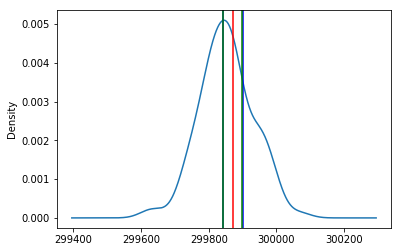

In [35]:
pd.Series(spd).plot.kde()
plt.axvline(t_ci[1], color = 'red')
plt.axvline(t_ci[0], color = 'blue')
plt.axvline(t_ci[2], color = 'blue')
plt.axvline(n_ci[0], color = 'green')
plt.axvline(n_ci[2], color = 'green')

Run the code repeatedly starting with 10 samples until you find the smallest value where you can no longer distinguish the difference between the Student-T distribution and the standard normal from the plot. Enter that number below.

30

# Confidence limits of polling data [25 points]

*N.B.* Although this problem involves political polling data, I want to assure you that we're just looking for a good dataset for polling.

The website [538](https://projects.fivethirtyeight.com/trump-approval-ratings/?ex_cid=rrpromo) runs a series of "weighted" polls to estimate e.g. the popularity of the current president or other electorial outcomes.

They include a number of polls. One of them, the [Feb 25-March 1 2018 IPSO poll](http://polling.reuters.com/#poll/CP3_2/), shows an approval rating of 38.2%, with a reported range of 35.6%-40.9% with a sample size of 1488. This means that $n*\hat p = 568$ people of 1488 reported approval.

There's no mention of how the estimate range 35.6%-40.9% is determined. Let's see if we can reverse engineeer the different methods we've heard about and see which they use.

In [36]:
n = 1488
support = 568
pest = support/n

### Wilson estimate

Using the "Wilson method" described in the text, report the 95% confidence interval. You can either work out the solution long hand and then enter the calculations below to determine the confidence interval or you [can cheat and use the SymPy package to solve the equations](http://docs.sympy.org/latest/modules/solvers/solvers.html).

In [37]:
temp = (1.96**2)/1488

np.roots([temp+1,-2*pest-temp,pest**2])

array([ 0.40667933,  0.35737069])

### Normal approximation with specified $\hat p$

The central limit theorem says that estimates for $S_n = X_1 + \ldots + X_n$ should follow a standard normal distribution with mean $E[S_n]/n = p$ and variance $Var[S_n] = Var[X]/n$ or $\sigma = \frac{\sqrt{p(1-p)}}{n}$. 

Perhaps Reuter's uses the specified value of $\hat p$ in order to determine the variance or standard deviation? Run the numbers to compute the 95% confidence interval using the standard normal approximation.

In [38]:
# your code here
n_mean = pest
n_std = np.sqrt(pest*(1-pest))/ n
n_rv = stats.norm(loc = n_mean, scale = n_std )
n_ci = [n_rv.ppf(0.025), n_rv.ppf(0.975)]
n_ci

[0.38108053275974446, 0.38236032745530929]

### Student-T approximation with specified $\hat p$

Perhaps they're using the Student-T distribution instead of the standard normal despite the large sample size? Give that a try and compute the 95% confidence interval using the student-T distribution.

In [39]:
t_mean = pest
t_std = np.sqrt(pest*(1-pest))/ n
t_rv = scipy.stats.t.ppf(.975, n-1 )

upt = t_mean + t_std * t_rv
lowt = t_mean - t_std * t_rv

t_ci = [lowt, upt]
t_ci
#student_t_approx = np.percentile(pest, [2.5, 97.5])
#print(student_t_approx[0], student_t_approx[1])

[0.3810800114892352, 0.38236084872581855]

### Worst case variance?

As mentioned in lecture, if we don't know the precise value of $\hat p$, it's difficult to estimate the varince since that depends on $\hat p$; the Wilson method is precise but annoyingly complex.

However, because we know that the variance is maximal at $p=1/2$ we can use that to compute a conservative bound. Use that approximation and the standard normal assumption to compute a bound on the 95% confidence interval.

In [40]:

n_std_2 = np.sqrt(.25)/ n
n_rv_2 = stats.norm(loc = n_mean, scale = n_std_2 )
n_ci_2 = [n_rv.ppf(0.025), n_rv.ppf(0.975)]
n_ci_2 

[0.38108053275974446, 0.38236032745530929]

### Give it your best guess.

What method do you think Reuter's used?

Used Wilson's Estimate